# Pseudotime using spectral embedding

In [1]:
%matplotlib inline
import numpy as np
import math
import os
from numpy.matlib import repmat
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy import optimize
from OscopeBootstrap.pseudotime import estimate_pseudotime_using_spectral_embedding, calculate_metrics, \
    plot_latent_space, plot_latent_space_notrue, plot_gene_fits, plot_gene_fits_notrue, plot_correspondence_of_peaktime_and_times

## Define a test sin function for the fitting

In [19]:
#def testsin(x,a,b):
#    return a*np.sin(b*x)

def testsin_phase(x,a,b,p):
    return a*np.sin(p + b*x)
#def testsin_phase(x, dist, a,b,p):
#    return dist + a * np.sin(p + b*x)

## Load data

In [20]:
case='3groupsGap'
path_to_data = '../Glioblastoma_project/Simulations/'
path_to_comm = '../Glioblastoma_project/Results_Sim/'
fig_root='../Glioblastoma_project/Plots/'
path_to_fig=f'{fig_root}{case}/'
datafile=f'{path_to_data}{case}Data.csv'
data=pd.read_csv(datafile,header=0, index_col=0)
if not os.path.exists(path_to_fig):
    os.makedirs(path_to_fig)


In [21]:
data

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C790,C791,C792,C793,C794,C795,C796,C797,C798,C799
G1SO0,1.012309,0.946826,0.947580,0.932572,0.990663,0.907535,0.997849,1.022470,0.997516,0.923284,...,0.940912,0.994312,1.004409,1.012752,0.941598,1.027994,1.004490,0.956476,1.028576,0.927084
G1SO1,1.065841,1.007128,0.959793,0.960930,0.951394,1.031038,0.951302,0.945773,1.021170,1.129631,...,0.921003,0.883757,0.958510,0.978183,1.049107,0.953883,0.997417,0.986665,1.037244,0.943098
G1SO2,1.011227,1.041974,1.005119,1.010457,0.982969,1.027026,1.021951,1.028846,1.042634,0.982421,...,0.930181,0.938869,0.923788,0.989832,1.078956,0.882214,0.990798,0.917535,1.100136,0.998436
G1SO3,1.005671,0.978291,1.084076,0.988566,0.947996,1.037906,0.949655,1.072932,1.003588,0.971455,...,0.925999,1.052662,0.946846,1.029621,0.983953,0.973092,1.002050,0.991666,1.000986,0.990132
G1SO4,1.005268,1.020422,1.011671,0.966788,1.080750,1.036080,1.091862,0.971866,1.082332,0.951666,...,0.973896,0.924453,0.843207,0.992763,0.995126,0.950830,0.977354,0.925904,0.889427,1.008930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R95,0.185764,1.103811,-0.074598,1.745616,1.264708,1.474946,1.628149,-0.584184,2.464172,1.098017,...,-0.903763,-1.079459,1.370665,0.608228,2.560359,1.390152,1.257275,-0.612829,-0.964145,0.217267
R96,-0.225312,1.684564,0.107586,0.033260,-0.440007,-1.139728,0.007351,0.361468,0.116651,-0.480922,...,-0.508925,-1.923845,0.263698,0.636535,0.350887,2.985528,-1.121467,1.273153,0.746323,-0.542277
R97,0.814079,0.765794,-1.075396,-0.221962,1.076712,1.764596,-1.520892,1.316818,-0.208269,0.909346,...,0.526991,-0.806325,0.726426,-0.464782,0.587455,-0.508463,2.070090,-0.176617,1.141101,-1.410480
R98,-0.765919,-0.134629,-0.959256,-1.515769,-0.226346,0.937508,-0.168331,1.688103,-0.606260,0.805281,...,-1.180734,1.382740,0.546018,0.215571,-0.801982,-0.737628,0.116438,0.430923,-0.223957,0.097302


## load community info

In [22]:
commDataFile=f'{path_to_comm}{case}Comm.csv'
commReportFile=f'{path_to_comm}Report{case}.csv'
commData = pd.read_csv(commDataFile,header=0, index_col=1)
commData=commData[['CommunityID']]
genelist=commData.index.values
ncomm=commData.max()
commInfo=pd.read_csv(commReportFile,header=0, index_col=1)
print(commReportFile)

../Glioblastoma_project/Results_Sim/Report3groupsGap.csv


In [23]:
commInfo=commInfo.sort_index()


In [24]:
#commInfo

In [25]:
communities=commInfo.index.values
currentCFlag=commInfo.loc[communities==1,'LinFlag']
print(currentCFlag.values)
#selecting  linear clusters:

Linear=commInfo[commInfo.LinFlag==1]
LinearId=Linear.index.values
#selecting  non linear clusters:
print('Linear Communities')
print(LinearId)
NonLinear=commInfo[commInfo.LinFlag==0]
NonLinearId=NonLinear.index.values
print('Non Linear Communities')
print(NonLinearId)

[1]
Linear Communities
[1 2 3 4 5 6 7 8]
Non Linear Communities
[ 9 10 11]


# Get data for the community of interest - Linear Case

LINEAR COMMUNITIES PLOT
Community=
1
(7, 800)
Spectral pseudotime time
Gene plots
[ 0.96879817  6.32477997 -4.39893189]
[ 0.95472434 -6.31188498  1.43224816]
[ 0.95430836  6.34364622 -1.43961724]
[ 0.95530088 -6.2801177   1.7310092 ]
[ 0.97399385  6.31000379 -4.51081889]
[ 0.95221446  6.22300377 -1.86422486]
[ 0.95410523  6.27116749 -1.87145028]
Community=
2
(5, 800)
Spectral pseudotime time
Gene plots
[ 0.8928663  -6.40165422  1.62858902]
[ 0.88941558  6.46083714 -1.62703892]
[ 0.90473375 -6.43073009  1.6412598 ]
[ 0.91708307 -6.43291201  1.63662727]
[ 0.90381113 -6.4385363   1.61776226]
Community=
3
(11, 800)
Spectral pseudotime time
Gene plots
[ 0.91919786  6.23568265 -1.58089275]
[ 0.91745445  6.21255609 -1.57262353]
[ 0.91891235  6.23020154 -1.57610613]
[ 0.9182824   6.22097452 -1.5756252 ]
[ 0.91987353  6.22586619 -1.58131267]
[ 0.91839171  6.23624827 -1.57938131]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.91956997  6.2051846  -1.57349113]
[ 0.92016729  6.21273017 -1.56962376]
[ 0.91897782  6.24312972 -1.58230582]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.9186569   6.24089716 -1.58835369]
[-0.28825425 13.11449373 -7.16285745]
Community=
4
(5, 800)
Spectral pseudotime time


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))


Gene plots
[ 0.92034612  6.45592724 -1.66096547]
[ 0.92844452  6.45402495 -1.64998621]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.92636119  6.47189074 -1.66340854]
[ 0.92565968 -6.46198551  1.6588688 ]
[ 0.92633777  6.47940128 -1.66914959]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
5
(3, 800)
Spectral pseudotime time
Gene plots
[ 0.9249194   6.45409052 -1.65579507]


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

[ 0.92193156 -6.4583359   1.65724523]
[ 0.91789315 -6.49962024  1.69416123]
Community=
6
(10, 800)
Spectral pseudotime time
Gene plots
[ 0.94227515 -6.3264247   1.58726748]


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

[ 0.9411997  -6.32497954  1.5835348 ]
[ 0.94561434 -6.3368019   1.59495159]
[ 0.93784681 -6.32287049  1.58111275]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34

[ 0.9327746  -6.38623026  1.61428406]
[ 0.9415567  -6.34563577  1.60439968]
[ 0.94160166 -6.34786171  1.59852686]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93355402 -6.38835095  1.62106733]
[ 0.93831924 -6.37403639  1.62142238]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.95100888 -6.30843733  1.58430827]
Community=
7
(10, 800)
Spectral pseudotime time


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Gene plots
[ 0.91390213 -6.40445774  1.64183521]
[ 0.91076782 -6.44983304  1.6595974 ]
[ 0.91963313 -6.45017306  1.67900799]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.92803714 -6.40435662  1.64639985]
[ 0.9212005  -6.3762725   1.62559491]
[ 0.91106777 -6.46613387  1.67113396]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.91619139 -6.40982926  1.64407314]
[ 0.92139896 -6.39455659  1.63243861]
[ 0.91491602 -6.44266516  1.65680879]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.91611309 -6.39981781  1.6329092 ]
Community=
8
(10, 800)
Spectral pseudotime time


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `

Gene plots
[ 0.95180355 -6.34384437  1.62189126]
[ 0.95512322 -6.33077176  1.61509579]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.95348682 -6.32686539  1.6154986 ]
[ 0.95913504 -6.320651    1.61737868]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.94818502 -6.33386602  1.61515386]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.94932515 -6.35477819  1.62976883]
[ 0.95193112 -6.32994867  1.61912875]
[ 0.95321775 -6.31765633  1.60967438]


<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-26-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.95352078 -6.34613929  1.6267457 ]
[ 0.95534653 -6.33264718  1.62045177]


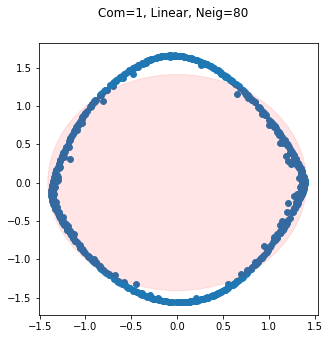

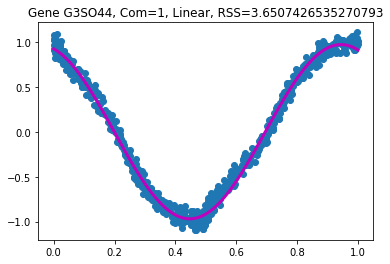

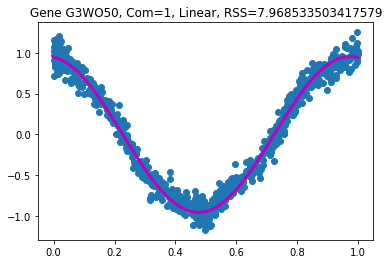

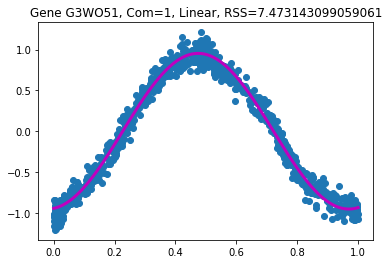

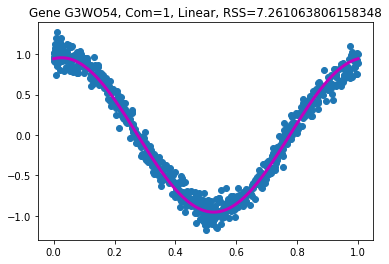

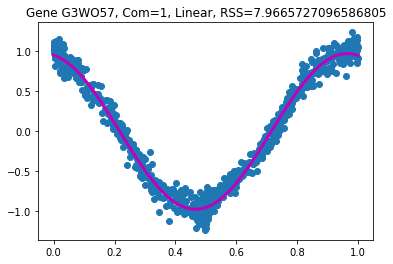

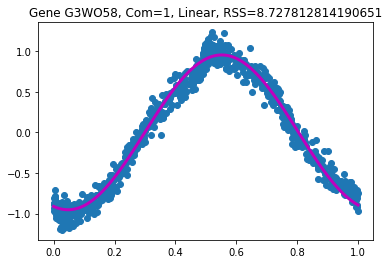

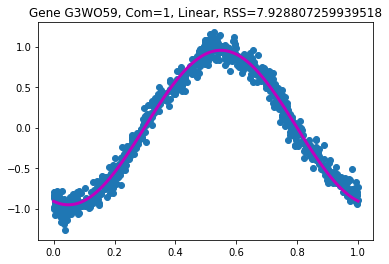

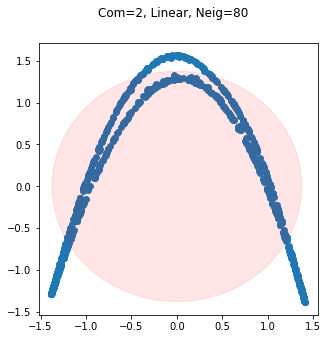

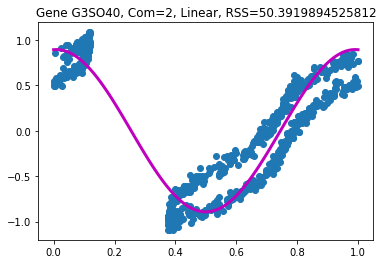

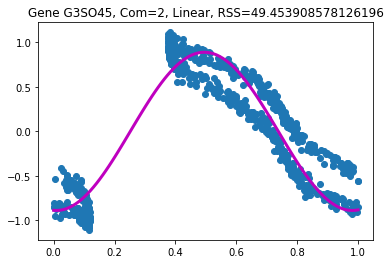

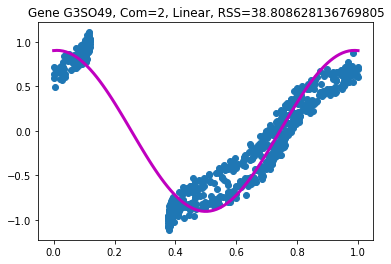

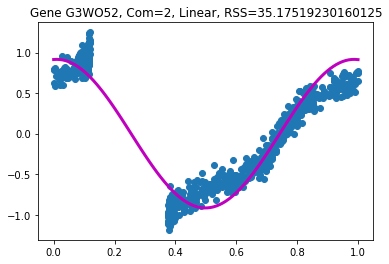

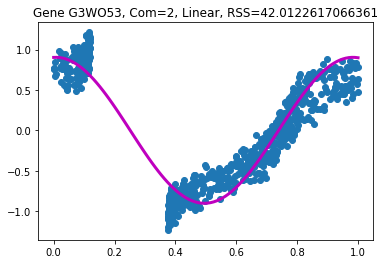

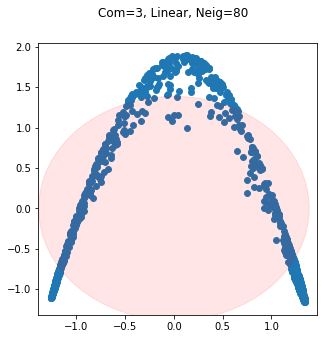

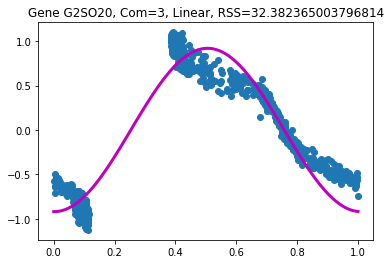

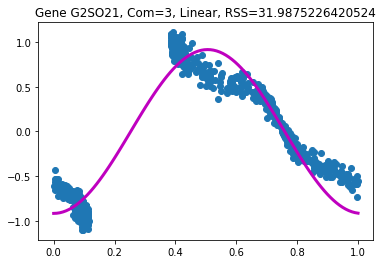

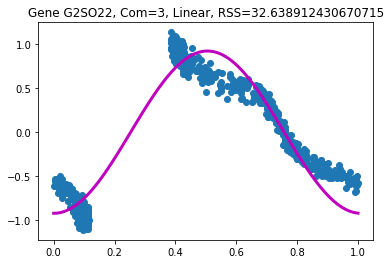

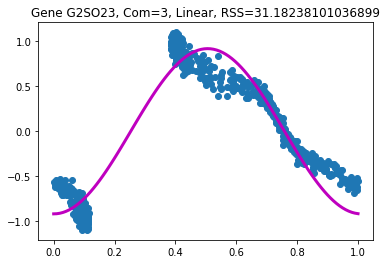

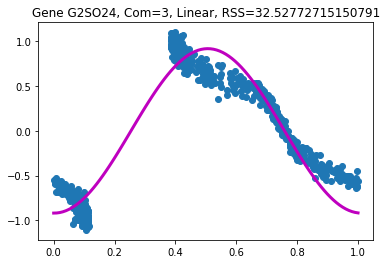

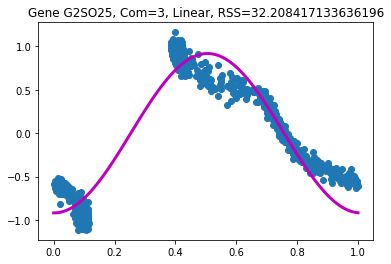

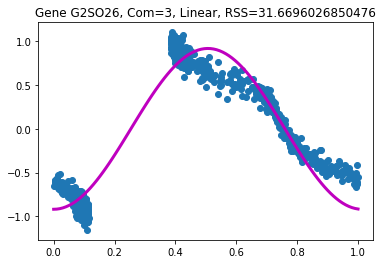

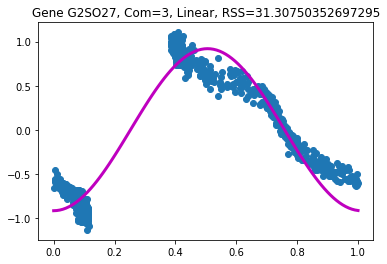

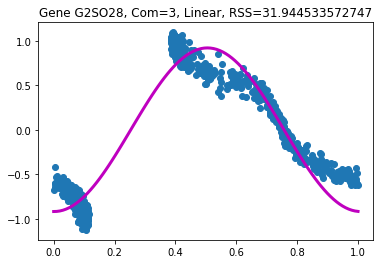

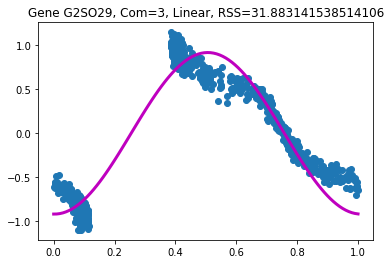

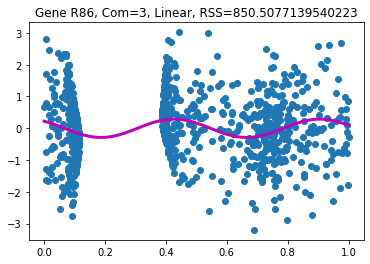

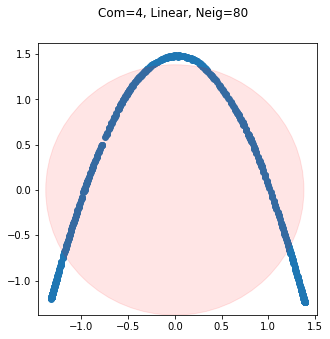

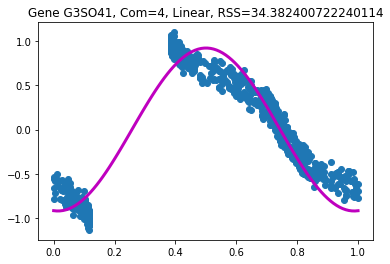

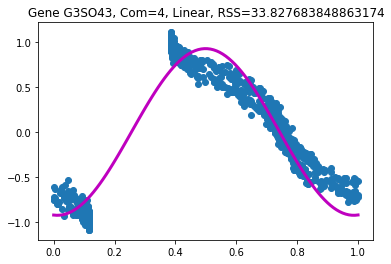

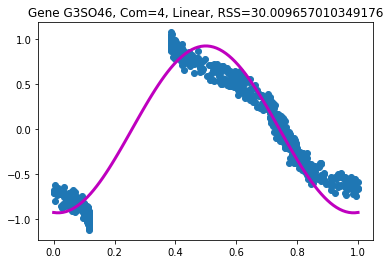

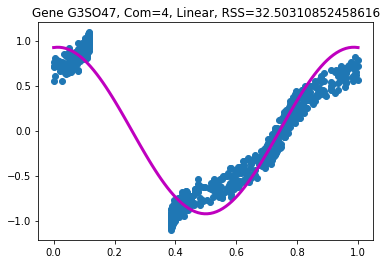

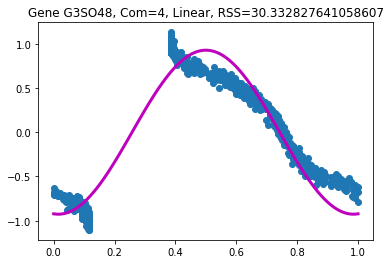

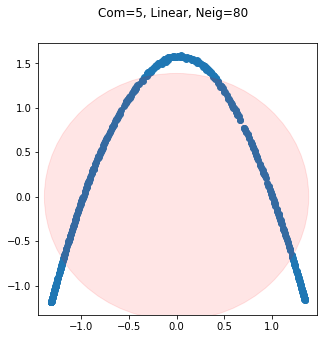

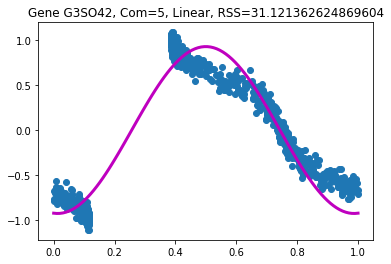

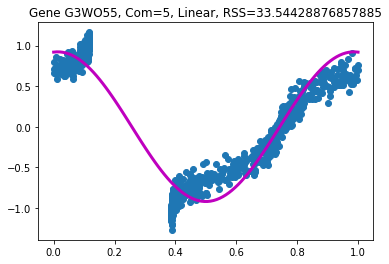

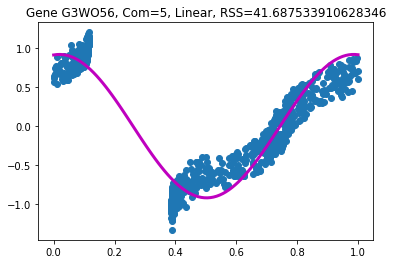

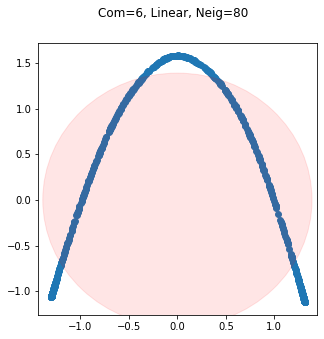

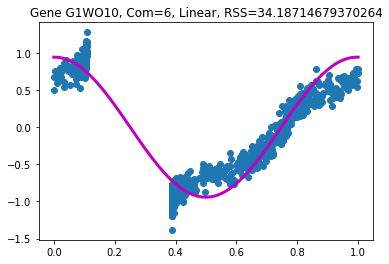

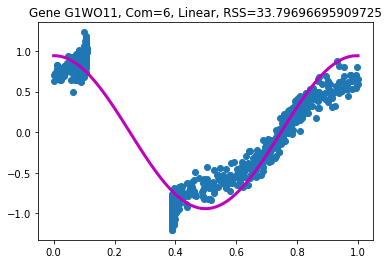

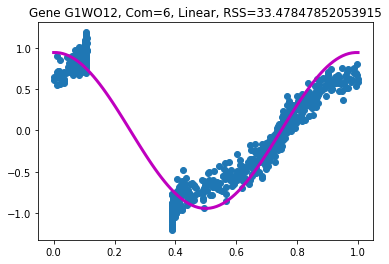

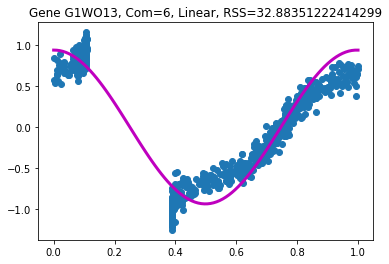

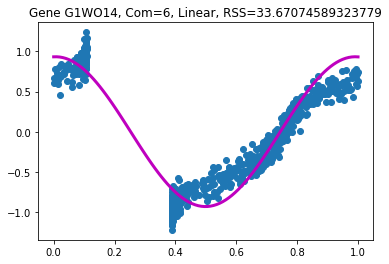

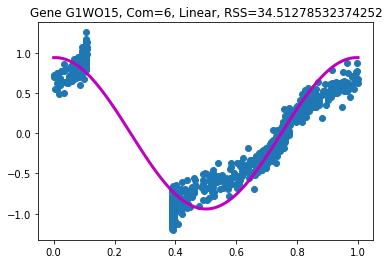

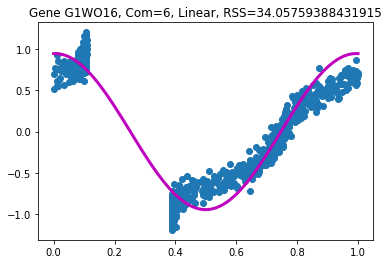

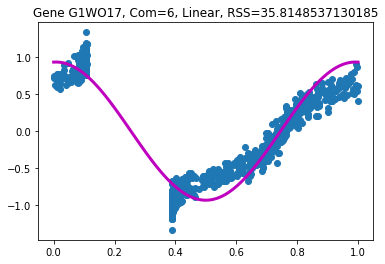

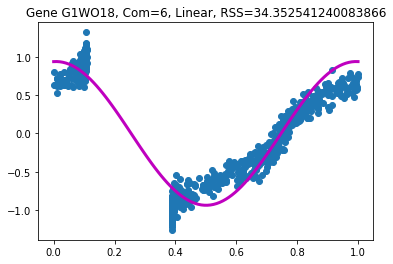

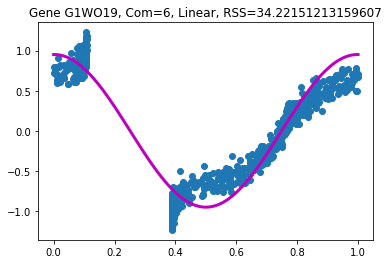

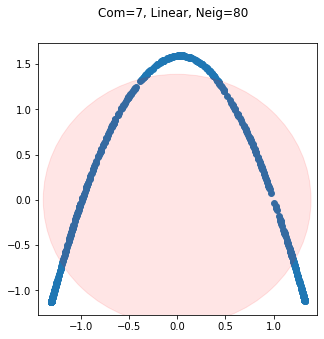

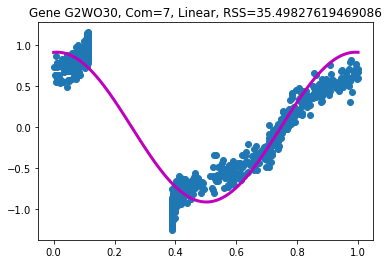

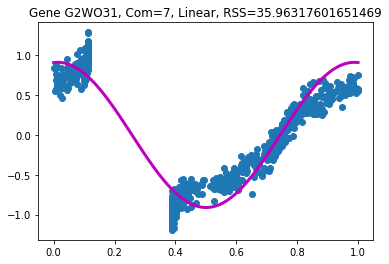

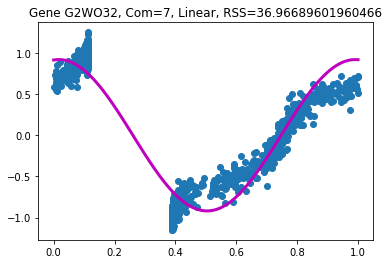

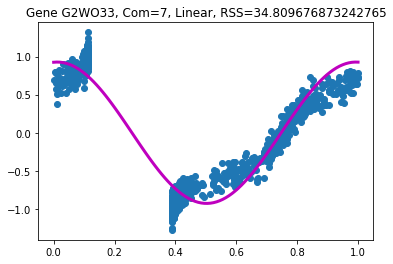

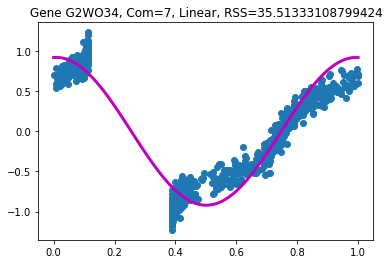

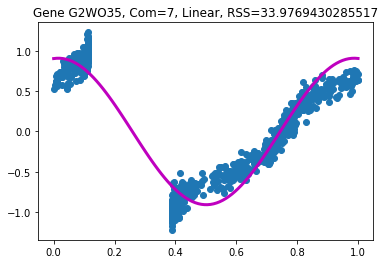

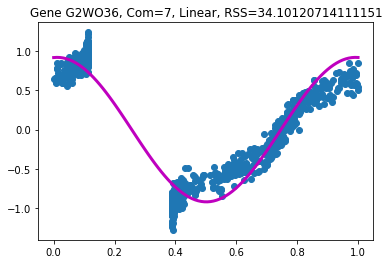

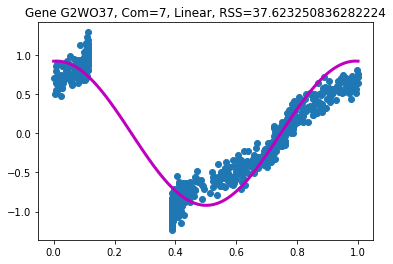

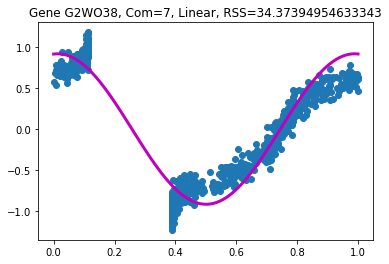

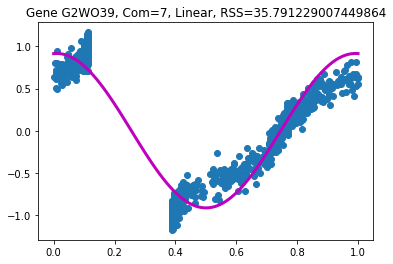

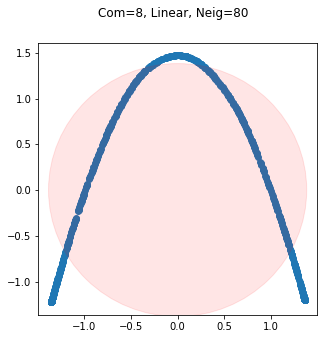

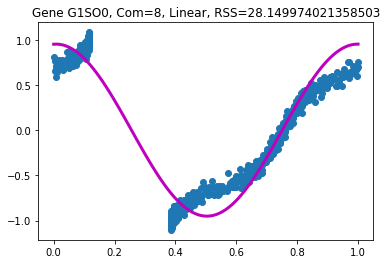

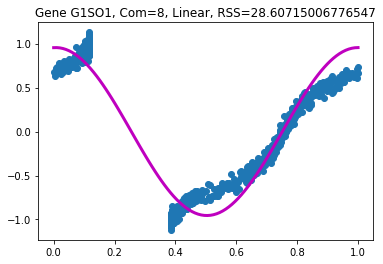

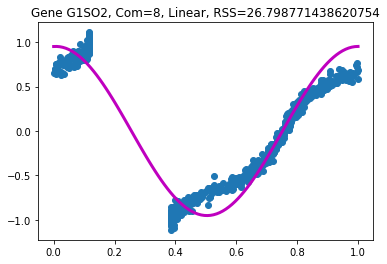

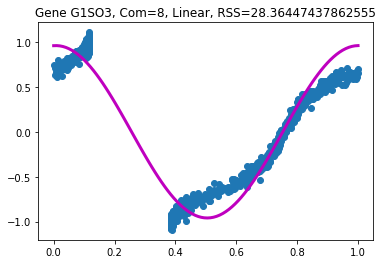

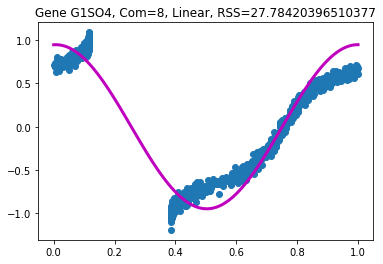

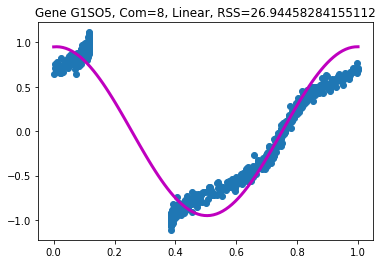

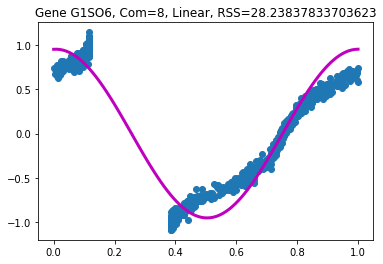

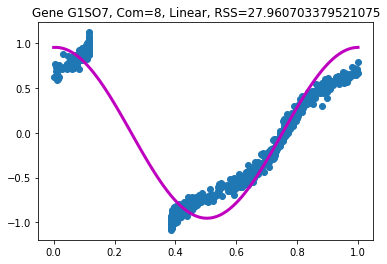

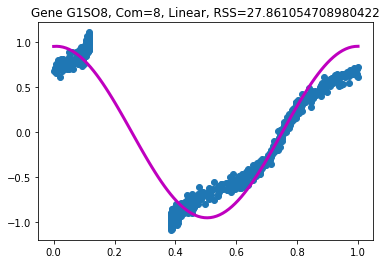

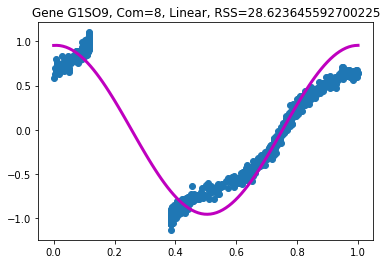

In [26]:
#Start from the linear communities
print('LINEAR COMMUNITIES PLOT')
for commId in LinearId:
    print('Community=')
    print(commId)
    #commId=LinearId[4]
    Flag="Linear"
    comm = commData[commData.CommunityID == commId]
    #select ONLY the genes in the selected community to use laterin the plot
    genelist=comm.index.values
    training_data=data.loc[comm.index] 
    nsamp=training_data.shape[1]
    print(training_data.shape)

    n_neighbors=math.ceil(nsamp/10)
    n_neighbors
    print('Spectral pseudotime time')
    pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
    [fig, ax] = plot_latent_space_notrue(latent_space_2d)
    PseudoTimefile=f'{path_to_fig}LinearPseudotime{case}_comm_{commId}.pdf'

    pt = PdfPages(PseudoTimefile)
    fig.suptitle("Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors))
    fig
    pt.savefig(fig)

    pt.close()
    print('Gene plots')
    geneplot=genelist 
    idx=np.argsort(pt_spectral)
    figfile=f'{path_to_fig}PlotfilterSin{case}_comm_{commId}.pdf'
    pp = PdfPages(figfile)
    for g in geneplot:
        f=plt.figure()
        gene_series = data.loc[g][idx]
        params,params_covariance=optimize.curve_fit(testsin_phase,pt_spectral[idx],gene_series,p0=[2,2,0])
        #fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
        print(params)
        xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
        #fs = fspline(xtest)
        ts=testsin_phase(xtest,params[0],params[1],params[2])
        #plt spline
        residuals=gene_series-testsin_phase(pt_spectral[idx],params[0],params[1],params[2])
        rss=sum(residuals**2)
        
        plt.plot(xtest, ts, color='m', lw=3);
        #plot data
        plt.scatter(pt_spectral[idx],gene_series)
        plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', RSS=' +str(rss) )
        pp.savefig(f)
    pp.close()

# Get data for the community of interest - Non Linear Case

Community=
9
(2, 800)
[ 1.25134447  6.12320149 -3.96066813]
[-1.23485995  5.94212058 -2.21417499]
Community=
10
(2, 800)
[ 1.234213    6.16265918 -3.47657701]
[ 1.28998506 -6.24625856  1.88923997]
Community=
11
(2, 800)
[ 1.27384934 -6.26866838  2.27466133]
[ 1.27621798  6.36506393 -3.88754755]


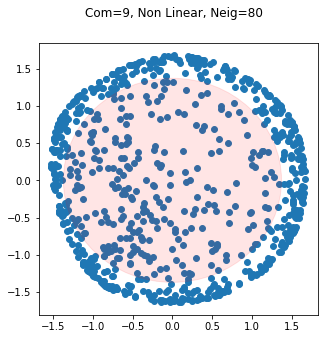

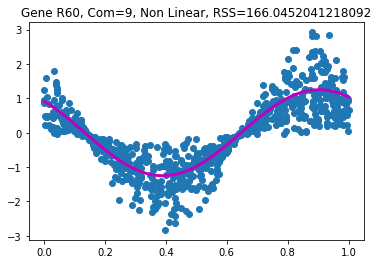

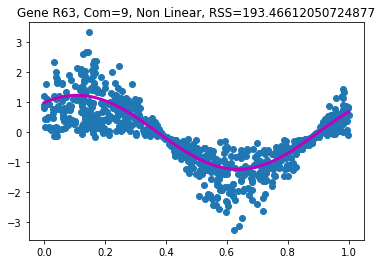

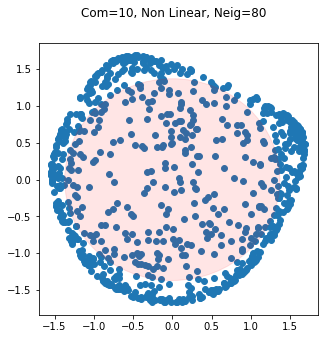

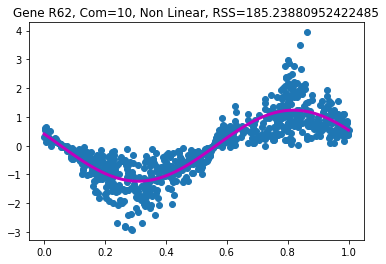

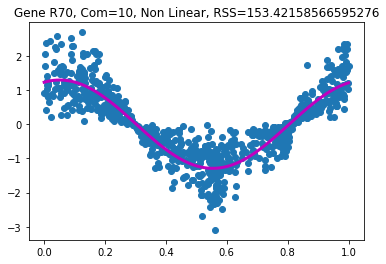

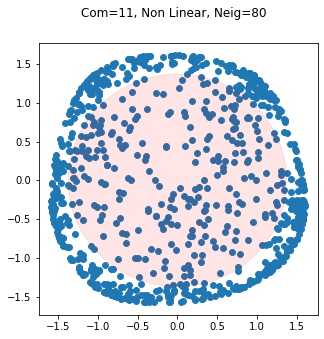

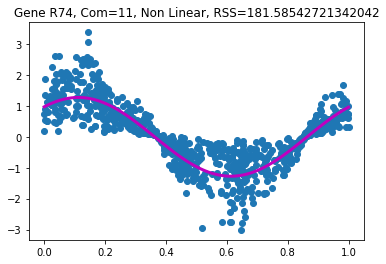

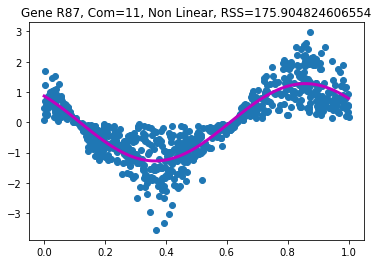

In [27]:
#Start from the linear communities
for commId in NonLinearId:
    print('Community=')
    print(commId)
    #commId=NonLinearId[12]
    Flag="Non Linear"
    comm = commData[commData.CommunityID == commId]
    #select ONLY the genes in the selected community to use laterin the plot
    genelist=comm.index.values
    training_data=data.loc[comm.index]
    nsamp=training_data.shape[1]
    print(training_data.shape)
    n_neighbors=math.ceil(nsamp/10)
    n_neighbors
    pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
    [fig, ax] = plot_latent_space_notrue(latent_space_2d)
    PseudoTimefile=f'{path_to_fig}NonLinearPseudotime{case}_comm_{commId}.pdf'
    pt = PdfPages(PseudoTimefile)
    fig.suptitle("Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors))
    fig
    pt.savefig(fig)
    pt.close()
    #Plot genes
    geneplot=genelist
    idx=np.argsort(pt_spectral)
    figfile=f'{path_to_fig}PlotfilterSin{case}_comm_{commId}.pdf'
    pp = PdfPages(figfile)
    for g in geneplot:

        f=plt.figure()
        gene_series = data.loc[g][idx]
        #fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
        params,params_covariance=optimize.curve_fit(testsin_phase,pt_spectral[idx],gene_series,p0=[2,2,0])
        print(params)
        xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
        #fs = fspline(xtest)
        ts=testsin_phase(xtest,params[0],params[1],params[2])
        residuals=gene_series-testsin_phase(pt_spectral[idx],params[0],params[1],params[2])
        rss=sum(residuals**2)
        #fs = fspline(xtest)
        #plt spline
        plt.plot(xtest, ts, color='m', lw=3);
        #plot data
        plt.scatter(pt_spectral[idx],gene_series)
        plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', RSS=' +str(rss) )
        pp.savefig(f)
    pp.close()
    
